<a href="https://colab.research.google.com/github/kuroneko913/lab/blob/master/DNACodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DNAコード



DNAからタンパク質(アミノ酸列)が合成されるプロセスをモデル化し、暗号に利用したもの。

アミノ酸とコドンの関係が一意に定まれば、DNAから合成されるアミノ酸列も一意に定まる。

この暗号化方式は、コドンに対応するアミノ酸の種類を鍵として暗号化する。
64通りのコドンは20種類のアミノ酸に対応している。


暗号化 (DNAへの変換)
1. 平文を0~19の19進数に変換し、アミノ酸に対応させる　
2. 鍵として定義してあるアミノ酸とコドンの関係から、アミノ酸列をコドン列に変換する
3. 情報の開始と終了時にはそれぞれ特別なコドン、開始コドンと終止コドンを配置する
4. 必要に応じてデタラメな塩基配列を追加して難読化する
5. コドン列をmRNAとみなす。(本来なら、DNAからmRNAが合成される)
6. mRNAに対応するDNAを塩基の持つ相補性により合成する

復号 (アミノ酸列への変換, DNAからアミノ酸の合成プロセス)
1. DNAを相補性を用いてmRNAに変換する
2. mRNAには、不要な情報を含む部分（イントロン）があるので、その部分をカットして必要な部分だけにする(スプライシング)
3. 具体的にはmRNAを読みながら開始コドンを探し出し、そこから終止コドンが見つかるまで翻訳してアミノ酸列に変換していく
4. 得られたアミノ酸列を19進数->10進数の変換をすることで平文を得る



In [0]:
from numpy.random import randint, choice
import pickle
import numpy as np
from datetime import datetime
from more_itertools import chunked
from tqdm import tqdm

In [0]:
# 実験用
from IPython.display import Image, display_png

In [0]:
# Codon

class Codon:
    def __init__(self,key):
        # コドンのパターンを生成
        self.cdn_ = self.make_cdn_list()
        self.key  = key
        # 開始コドン
        self.start_cdn='AUG'
        # 終止コドン
        self.end_cdn=['UAA','UAG','UGA']
        
        # コドンに対応するアミノ酸
        self.cdn_amino=['Phe','Leu','Ile','Val','Ser','Pro','Thr','Ala','Tyr','His',
                        'Gln','Asn','Lys','Asp','Glu','Cys','Trp','Arg','Gly','Met','END']
        
        # アミノ酸とコドンの対応関係
        self.cdn_num=[[0,1],[2,3,4,5,6,7],[8,9,10],[12,13,14,15],[16,17,18,19,56,57],[20,21,22,23],
                      [24,25,26,27],[28,29,30,31],[32,33],[36,37],[38,39],[40,41],[42,43],[44,45],
                      [46,47],[48,49],[51],[52,53,54,55,58,59],[60,61,62,63],[11],[34,35,50]]
        
        self.convert_dic = {}
        self.iconv_dic = {}
        self.set_new_dic()
        # codon番号からアミノ酸を特定するdictionary
        for key,value in self.convert_dic.items():
            for v in value:
                self.iconv_dic[v]=key
                
        self.cdn2amino = {self.cdn_[k]:self.cdn_amino[v] for k,v in self.iconv_dic.items()}
                
    def __getitem__(self,idx):
        return self.cdn_[idx]

    # mRNAのコドンリストの作成
    def make_cdn_list(self):
        cdn=[]
        for a in ['U','C','A','G']:
            for b in ['U','C','A','G']:
                for c in ['U','C','A','G']: 
                    cdn.append(b+a+c)
        return cdn
    
    # コドンとアミノ酸の再マッピング
    def set_new_dic(self):
        self.convert_dic = { self.key[i]: self.cdn_num[i]  for i in range(len(self.key)) }
        self.convert_dic[20]=self.cdn_num[20]
        
    # コドンとアミノ酸の関係をリセット
    def reset_dic(self):
        self.convert_dic = {i: self.cdn_num[i]  for i in range(20) }
        self.convert_dic[i] = self.cdn_num[20]

    # 複数のコドンから一つをランダムに選択
    def choice_pattern(self,number):
        return choice(self.convert_dic[number])
    
    # 20種類のアミノ酸からランダムにn個選択
    def choice_amino(self, n=1):
        return list(choice(list(range(20-1))+[20],n))


In [0]:
# mRNA

class mRNA:
    def __init__(self):
        self.text = ''
        self.segment = ''
        self.toRNA={'A':'U','T':'A','G':'C','C':'G'}
        self.cdn_ = None
        self.iconv_dic = None
        
    def __call__(self):
        return self.text

    def set_codon(self,key):
        self.cdn_ = Codon(key)
        self.iconv_dic = self.cdn_.iconv_dic
    
    # DNA --> mRNA
    def translate(self, DNA):
        self.text += ''.join([self.toRNA[dna] for dna in DNA])
            
    # アミノ酸からコドンへの変換(mRNAの生成)
    def amino2codon(self,amino_id):
        self.segment += self.cdn_[self.cdn_.choice_pattern(amino_id)]

    # コドンからアミノ酸への変換
    def codon2amino(self,codon):
        amino_id = self.iconv_dic[self.cdn_.cdn_.index(codon)]
        return amino_id, self.cdn_.cdn_amino[amino_id]
        
    # 開始コドンの追加
    def add_start_codon(self):
        self.segment += self.cdn_.start_cdn

    # 終止コドンの追加
    def add_end_codon(self):
        self.segment += self.cdn_[self.cdn_.choice_pattern(20)]

    # 開始コドンの前や終止コドンのあとに無意味なコドン列を追加して高度に暗号化
    # スプライシングの逆の工程
    def padding(self,length=20):
        self.segment += ''.join(list(map(lambda x:self.cdn_[x], map(lambda x:self.cdn_.choice_pattern(x), self.cdn_.choice_amino(length)))))


In [0]:
# DNA
class DNA:
    def __init__(self):
        self.text = ''
        self.toDNA = {'U':'A','A':'T','C':'G','G':'C'}
        self.dic = {'A':'T','T':'A','G':'C','C':'G'}
        
    def __call__(self):
        return self.text
        
    # mRNA --> DNA
    def translate(self,mRNA):
        self.text += ''.join([self.toDNA[rna] for rna in mRNA])# DNA化(暗号化)・アミノ酸列化(復号化)

In [0]:
# Codon Parser

class CodonParser:
    def __init__(self,codon,silent_mode = False):
        self.codon = codon
        self.__act = False
        self.start_cdn = self.codon.start_cdn
        self.end_cdn = self.codon.end_cdn
        self.silent_mode = silent_mode
        self.parsed_list = []
        self.parsed_result = []

    def __call__(self,binary_mode):
        if (binary_mode is False): 
            return ''.join(list(map(chr,self.parsed_result)))
        else: 
            return bytearray(self.parsed_result)
        
    def parse(self,cdn):
        if cdn in self.start_cdn and self.__act is False or cdn in self.end_cdn and self.__act is True:
            self.__switch_act()
            return None
        if self.__act is False:
            return None
        if not(self.silent_mode):
            print(cdn)
        return cdn

    def append(self,x):
        return self.parsed_list.append(x)
    
    def __free(self):
        self.parsed_list = []
    
    def convert(self):
        converted_value = self.Base_n_to_10(list(map(lambda x:x[0],self.parsed_list)))
        self.parsed_result.append(converted_value)
        self.__free()
    
    def __switch_act(self):
        self.__act = not(self.__act)
        if self.__act and not(self.silent_mode):
            print("### Parse Start ###")
        if self.__act is False:
            if not(self.silent_mode):
                print("### Parse Stop ###")
            self.convert()

    # n進数(0~n-1)を10進数に変換
    def Base_n_to_10(self, n_list, n=19):
        return np.sum([n**i*o for i,o in enumerate(reversed(n_list))])


In [0]:
class DNAcode:
    def __init__(self,key=[],padding=False,visual_mode=False,silent_mode=False, binary_mode=False):
        self.padding = padding
        self.visual_mode = visual_mode
        self.silent_mode = silent_mode
        self.binary_mode = binary_mode
        
        if len(key)==0 or len(key)!=21:
            self.key_generator()
        else:
            self.key = key
        self.mRNA = mRNA()
        self.mRNA.set_codon(self.key)
        self.DNA = DNA()
        
    # mes -> DNA
    def mes2code(self,mes):
        """text -> mRNAオブジェクト,DNAオブジェクト,amino(text)"""
        self.DNA = DNA()
        self.mRNA.text = ''
        amino = ''
        try:
            self.Base_10_to_n(mes[0][0])
            f = lambda x:self.Base_10_to_n(x)
            self.binary_mode = True
        except:
            f = lambda x:self.Base_10_to_n(ord(x))
            self.binary_mode = False
        for m in tqdm(mes):
            self.mRNA.segment = ''
            # 前後にpadding
            self.mRNA.padding(randint(10)) if self.padding is True else ''

            # コドン列への変換
            self.mRNA.add_start_codon() if self.binary_mode is False else ''
            for c in m:
                self.mRNA.add_start_codon() if self.binary_mode is True else ''
                print(c,f(c)) if self.silent_mode is False else ''
                set(map(lambda x:self.mRNA.amino2codon(x),f(c)))
                self.mRNA.add_end_codon() if self.binary_mode is True else ''
            self.mRNA.add_end_codon() if self.binary_mode is False else ''

            self.mRNA.padding(randint(10)) if self.padding is True else ''

            self.DNA.translate(self.mRNA.segment)
            self.mRNA.text += self.mRNA.segment
            amino_ = [self.mRNA.cdn_.cdn2amino[''.join(o)] for o in chunked(self.mRNA.segment,3)]
            amino += '-'.join(amino_)+'-'
        return amino,self.DNA,self.mRNA

    # DNA -> mes
    def code2mes(self,dna):
        """DNAオブジェクトもしくは,DNAのtext --> 元のtext """
        code = dna.text if type(dna).__name__ == "DNA" else dna
        self.mRNA.text = ""
        self.mRNA.translate(code)
        p = CodonParser(self.mRNA.cdn_, self.silent_mode)
        m = chunked(self.mRNA(),3)
        for _ in tqdm(range(int(len(self.mRNA())/3))):
            try:
                cdn = p.parse(''.join(next(m)))
                if cdn is not None:
                    p.append(self.mRNA.codon2amino(cdn))
            except StopIteration:
                break
        return p(self.binary_mode)

    # 鍵となるアミノ酸とコドンの関係を生成
    def key_generator(self,extract=False):
        data=[]
        while len(data) < 19:
            tmp=randint(19)
            if tmp not in data:
                data.append(tmp)
        # 開始コドン用
        data.append(19)
        # 終止コドン用
        data.append(20)
        if self.silent_mode is False:
            print('\ngenerate new key pattern:',data)
        if extract:
            with open('key_file_{}.dkf'.format(),'wb')as f:
                pickle.dump(data,f)
        # set key data
        self.key=data

    # 10進数をn進数(0~n-1)に変換
    def Base_10_to_n(self, X, n=19):
        result0=[]
        tmp1,tmp2 = X,1
        while tmp2 >= 1:
            tmp2 = int(tmp1/n)
            result0.append(tmp1%n)
            tmp1 = tmp2
        return list(reversed(result0))



In [8]:
# いらすとやからpngファイルをダウンロードしてる...
!curl -O https://1.bp.blogspot.com/-AC1sM6NFLDg/XkZc3TcZh8I/AAAAAAABXQs/bBqpyDU0FTMpN5094w5pBwenw3Q96s4mgCNcBGAsYHQ/s1600/food_ramen_gekikara.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  356k  100  356k    0     0  21.7M      0 --:--:-- --:--:-- --:--:-- 21.7M


In [0]:
# pngファイルを暗号化するべくbinaryモードでopen
with open('food_ramen_gekikara.png', 'rb') as f:
    file_data = f.readlines()

In [19]:
# instanceを生成して、暗号化開始！
c = DNAcode(silent_mode=True,padding=False,binary_mode=True)
amino, dna, mrna = c.mes2code(file_data)

100%|██████████| 1445/1445 [00:16<00:00, 89.79it/s]


key: [9, 1, 10, 3, 16, 17, 7, 14, 8, 13, 15, 12, 11, 0, 18, 4, 2, 5, 6, 19, 20]


In [32]:
# pngファイルはDNA(A,T,G,Cの羅列)に変換される
print(dna.text[:1000])
# DNAを合成するのに用いられたmRNA鎖
print(mrna.text[:1000])
# mRNAを解読した結果のアミノ酸列
print(amino[:1000])

TACTGCACGACTTACACAACAACTTACACGACCACTTACCAGCGCATTTACGTAATCTACTATACTTACGAATGCATTTACTAAATCTACCTGATCTACCTAATCTACCTGATCTACGTAATCTACCAGAGGACTTACCATGTTATTTACCATTTTACTTACACGCCTACTTACCTGACTTACCTGACTTACACCATTTACAAGCAGACTTACCTAATTTACCTAATTTACACCACTTACAAACACACTTACATAACTTACCCTATTTACCTGATCTACCTGATTTACCTGACTTACGCTAATATTTACGTGATGACTTACATACCAACTTACCCCATTTACCTAATTTACCTGATCTACCTGATCTACACAACTTACCCTAATATCTACCAGAAAACTTACCACAGGATTTACACGATAACTTACATGATCTACATAACTTACATGATTTACATAACTTACCCGTATATTTACATGATCTACGCCTCCATTTACTGTCATACTTACCTAATCTACCTAATCTACCTAATCTACGCACTGATCTACCCAATGACTTACACGATAACTTACACATTAATCTACCCAACCATCTACACACCGATCTACTCTACCATTTACCCTGCTATTTACAACGTGACTTACGCAGGGATTTACCCGCTAACTTACGCTTCGATTTACGCGTGTATTTACGCGTATATTTACGCAGTGATCTACGCTCCCACTTACGATGTGACTTACCCCACCACTTACCCATGTATTTACTCTGGAATTTACTCTCCAATTTACGATGTGATCTACCACATGATTTACACAACAATCTACACAACGATTTACACCTTTATTTACCTGATTTACCTGATCTACATGACTTACATGGATATTTACTTTCTCATTTACCACGGGACTTACACACATATTTACTAAGTCATCTACCAACTTATTTACACCTGTATCTACTATTTAATCTACACGCTGATTTACACGTAGATCTACACCACCA

In [33]:
# 復号する
decoded_data = c.code2mes(dna())

100%|██████████| 1429432/1429432 [00:06<00:00, 212468.26it/s]


In [34]:
# 復号結果
print(decoded_data)

bytearray(b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xae\x00\x00\x02\xae\x08\x06\x00\x00\x00`\xff\x9e\x06\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00_zTXtRaw profile type APP1\x00\x00\x08\x99\xe3JO\xcdK-\xcaLV((\xcaO\xcb\xccI\xe5R\x00\x03c\x13.\x13K\x13K\xa3D\x03\x03\x03\x0b\x03\x0804006\x04\x92F@\xb69T(\xd1\x00\x05\x98\x98\x9b\xa5\x01\xa1\xb9Y\xb2\x99)\x88\xcf\x05\x00O\xba\x15h\x1b-\xd8\x8c\x00\x00 \x00IDATx\x9c\xec\xbd{\xb4mW]\xe7\xf9\xfd\xcd\xb9\xf6>\xfb\x9c{\xee\xfb\xde\xdc$\x90\xa7<\x82D\x11\xd1\xb2\x15,\x13^\xad(\x04\x04\xa2\xd8\xa3)P\x01)\xdb\xae\xea\xd6\xff\xaa\xc6\xb0\xabG\xf7\x18\xfd\x8fVY>\x00\xb1-\xb4K\xc4\x00F\x8cRJ\x80P\x8a]\x96"\xb4\nH\x90\x92\x10Brso\xee\xcd}\x9d\xc7\xde{\xad\xf9\xeb?\xe6\xeb7\xe7\x9a\xfb$(jH~\x9f1\x92\xbb\xcfz\xcc\xd7\x9ak\xcd\xef\xfc\xcd\xdf\x9c\x13P\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14EQ\x14

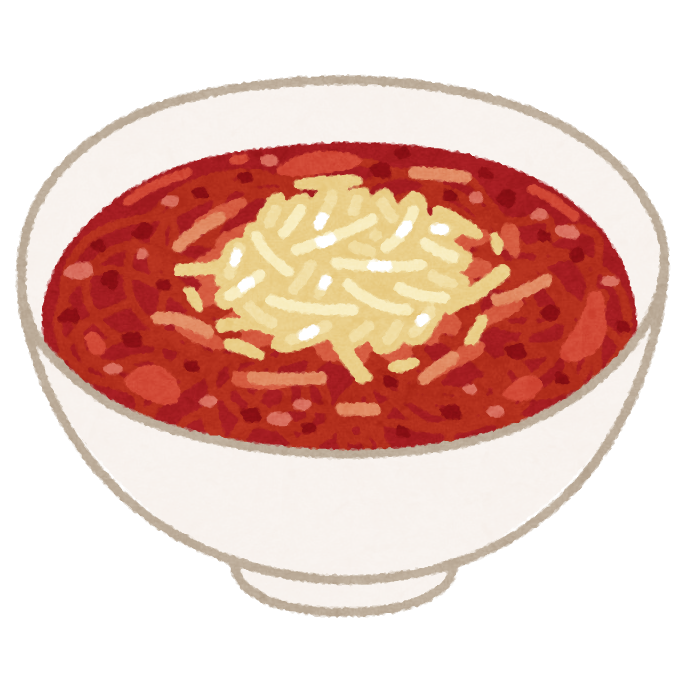

In [35]:
# ファイルに書き出して、表示する
with open('decoded_file.png','wb') as f:
    f.write(decoded_data)
display_png(Image('decoded_file.png'))

シンプルに文字列の暗号化


In [47]:
c = DNAcode(silent_mode=False,padding=True,binary_mode=False)
amino, dna, mrna = c.mes2code("テストです。元の文章が無事に復元できるといいのだけど！")

100%|██████████| 27/27 [00:00<00:00, 1324.98it/s]


generate new key pattern: [18, 16, 7, 9, 5, 10, 3, 11, 4, 0, 12, 1, 17, 6, 14, 15, 8, 13, 2, 19, 20]
テ [1, 15, 11, 3]
ス [1, 15, 10, 9]
ト [1, 15, 11, 5]
で [1, 15, 6, 3]
す [1, 15, 5, 8]
。 [1, 15, 0, 16]
元 [3, 0, 11, 17]
の [1, 15, 6, 10]
文 [3, 14, 18, 18]
章 [4, 11, 2, 11]
が [1, 15, 4, 14]
無 [4, 4, 4, 5]
事 [2, 17, 13, 5]
に [1, 15, 6, 7]
復 [3, 10, 15, 17]
元 [3, 0, 11, 17]
で [1, 15, 6, 3]
き [1, 15, 4, 15]
る [1, 15, 8, 1]
と [1, 15, 6, 4]
い [1, 15, 4, 6]
い [1, 15, 4, 6]
の [1, 15, 6, 10]
だ [1, 15, 5, 15]
け [1, 15, 5, 0]
ど [1, 15, 6, 5]
！ [9, 9, 15, 16]


In [51]:
print("\n",dna())
decoded_data = c.code2mes(dna())

100%|██████████| 440/440 [00:00<00:00, 28880.51it/s]


 AAGTCGACGGTCAACTACTTAACACGATGAATTGTCGAATGCATCACTACACAGTTTTACTTGACGGGCCATATTTGTTTCGACATTGACTCCGTACTGACGAAGCGCCGGGACCTCGGCTGACCAAATTACTTGACGCGGAGTATTCGCATTACACTGACCACCCTTCCCATGGTCTACTTGACGCTGTGCATTTGGTCAAAATTTTGTATACTATACTTGACGAGGACCACTCTTCCCCGCACCTCTTCGCACCATTACTTAACGGTAAACATTCCATGTACTTGCACCTGGACGATCCAACTTTTGTACTGCGTGCGATTCACTCTTACCGAATATTTTGTCAAGCTATAGTACTTAACACTGGGTATCAAAAGGCGTTAGCCAAGGCTTAGTCGCCGGCGGAGCTACTGGCTTAAGAAGATCCTCTCGATTCGTAAAGGACTTTAATTGTACATACGGCCTCGCATCATCATATTCCTCAGGGTATATTTTGCCCCCACCAAGTGTGCTGCATACTTAACGATGCTCATTTCGTGATACATAATGATGAGTATTGTCACTGTTCATTTAGCGCGGTGGCGGATACGGAATAGTTGGCGCTACCCCTTCGCGTCAATCACCCTCATTTAGTGAATTTTTAAATTTCGAACCACCGTTGACATATGATGTTACTTGACACTGTATACTATAGGAGGGTAACTGATCACAGAGAAAACAGAGGCACCCTACTGAGGGACATTCATCTGTGTCACCACAAAGATGTGTACCCGCGGGTTGATACCTATGGTACCCTACTGCGTGCGTTTCATTGTGAAACAAGTGAAATGACTTTGCCTAACCTATTACTTGACGCTATGGACTTTGACGTTTACTATGACGATTGTCCTGCGGAAAAGTAACTACTTGACGATGACGACTCTAGTAATCTTGTTGCTACCAACTGTTTACTTGACGACCTTGACTGCTCATTATATGTACTTGACGCTGATAACTAT

In [45]:
decoded_data

'テストです。元の文章が無事に復元できるといいのだけど！'

In [85]:
text = "AAGTCGACGGTCAACTACTTAACACGATGAATTGTCGAATGCATCACTACACAGTTTTACTTGACGGGCCATATTTGTTTCGACATTGACTCCGTACTGACGAAGCGCCGGGACCTCGGCTGACCAAATTACTTGACGCGGAGTATTCGCATTACACTGACCACCCTTCCCATGGTCTACTTGACGCTGTGCATTTGGTCAAAATTTTGTATACTATACTTGACGAGGACCACTCTTCCCCGCACCTCTTCGCACCATTACTTAACGGTAAACATTCCATGTACTTGCACCTGGACGATCCAACTTTTGTACTGCGTGCGATTCACTCTTACCGAATATTTTGTCAAGCTATAGTACTTAACACTGGGTATCAAAAGGCGTTAGCCAAGGCTTAGTCGCCGGCGGAGCTACTGGCTTAAGAAGATCCTCTCGATTCGTAAAGGACTTTAATTGTACATACGGCCTCGCATCATCATATTCCTCAGGGTATATTTTGCCCCCACCAAGTGTGCTGCATACTTAACGATGCTCATTTCGTGATACATAATGATGAGTATTGTCACTGTTCATTTAGCGCGGTGGCGGATACGGAATAGTTGGCGCTACCCCTTCGCGTCAATCACCCTCATTTAGTGAATTTTTAAATTTCGAACCACCGTTGACATATGATGTTACTTGACACTGTATACTATAGGAGGGTAACTGATCACAGAGAAAACAGAGGCACCCTACTGAGGGACATTCATCTGTGTCACCACAAAGATGTGTACCCGCGGGTTGATACCTATGGTACCCTACTGCGTGCGTTTCATTGTGAAACAAGTGAAATGACTTTGCCTAACCTATTACTTGACGCTATGGACTTTGACGTTTACTATGACGATTGTCCTGCGGAAAAGTAACTACTTGACGATGACGACTCTAGTAATCTTGTTGCTACCAACTGTTTACTTGACGACCTTGACTGCTCATTATATGTACTTGACGCTGATAACTATTGGCTGCTGTTTGTACTTGACAATACTAACTTGTCCGCTATAATGGCTAAAGTACTTAACAATACTGACTGAGACATGCACCGCAATTTTCGTCGGCGTCGCATACTTGACGCTAGGAACTACGTACTTGACAAGGACGACTTCTCTACGTCTCAAGGTCAATGGCGGTGGACAAATATACTTGACGTCAGTGATCTCGACTGGCCTGCGGTGGCAAGGACCTAAGTATTACTTGACGCTAAGTATCCTTCAATTCTTTTAGACGACAGTTAAGCGTGTGTACCACCACACGAATATTACCACTGCCTCGACCGATCGGTTG"
# key = [18, 16, 7, 9, 5, 10, 3, 11, 4, 0, 12, 1, 17, 6, 14, 15, 8, 13, 2, 19, 20]
# key = [18, 16, 7, 9, 5, 10, 3, 11, 0, 4, 12, 1, 17, 14, 6, 15, 8, 13, 2, 19, 20]
key =   [16,7,9,5,10,3,11,4,0,12,1,17,6,14,15,8,13,2,19,20,18]
c = DNAcode(key=key, silent_mode=True,padding=True,binary_mode=False)
decoded_data = c.code2mes(text)

100%|██████████| 440/440 [00:00<00:00, 187760.07it/s]


In [86]:
decoded_data

'𝌚𝌁𝌙\U0001d3d8\U0001d38e\U0001d3ae\U000137f7\U0001d3d0\U00013d20ܑ\U0001d2d2\n𠖷\U0001d3d6\U00012b92\U000137f7\U0001d3d8\U0001d2cb\U0001d3cb\U0001d3cd\U0001d2d1\U0001d2d1\U0001d3d0\U0001d389\U0001d38d\U0001d3d7趣'